In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

In [2]:
sales = pd.read_csv("C:\\Users\\DHRUBAJIT\\Desktop\\AnalyticsVidhya\\Big Mart Sales\\Big_Mart_Sales_train.csv")
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
sales.shape

(8523, 12)

### Handling missing values

In [4]:
sales.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
'''
Part 1: Item_Weight

Now I will impute the missing values in "Item_Weight" column by the mean of item_weight of each Item_type.
eg: For "Dairy" item_type, if there are any missing values in item_weight corresponding to Dairy, then I will impute the mean to 
that missing value.
This is checked and imputed for every unique Item_type.
'''

for i in sales.Item_Type.unique():
    group1 = sales[sales['Item_Type'] == i]
    ave = group1['Item_Weight'].mean()
    group1['Item_Weight'] = group1['Item_Weight'].fillna(ave)
   
    sales.loc[sales['Item_Weight'].isnull(),'Item_Weight'] = group1['Item_Weight']

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
'''
Part 2 --> Outlet_Size 

Does Outlet_Size depends upon Outlet_Type?
Let's find the mode of Outlet_Size based on Outlet_Type.
'''

outlet_size_mode = sales['Outlet_Size'].mode()[0]
sales['Outlet_Size'] = sales['Outlet_Size'].fillna(outlet_size_mode)

### Feature Engineering

In [7]:
'''
Part 1: Item_Fat_Content ---> correcting the misspelled items
'''
sales = sales.replace({'Item_Fat_Content' : { 'low fat' : 'Low Fat', 'LF' : 'Low Fat', 'reg' : 'Regular' }})

In [8]:
'''
Part 2: Outlet_Establishment_Year ---> calculating no. of years
'''

sales['Outlet_Establishment_Year'] = 2017 - sales['Outlet_Establishment_Year']

In [9]:
'''
Part 3: Item_type_new ---> in "Item_Type", we have many unique items and in "Item_Identifier", all these unique items are divided
into 3 groups, i.e. Food, Drinks and non-consumable.

So, "Item_type_new" will contain these 3 groups.
'''

sales['Item_Identifier'].value_counts()
sales['Item_type_new'] = sales['Item_Identifier'].apply(lambda x: x[0:2])
sales['Item_type_new'] = sales['Item_type_new'].map({'FD': 'Food', 'NC':'Non-consumable','DR':'Drinks'})
sales['Item_type_new'].value_counts()

Food              6125
Non-consumable    1599
Drinks             799
Name: Item_type_new, dtype: int64

### EDA and Hypothesis Testing

#### Fat content VS sales

Count of each item fat content:
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Mean Item outlet sales:
                  Item_Outlet_Sales
Item_Fat_Content                   
Low Fat                 2157.711534
Regular                 2224.561170


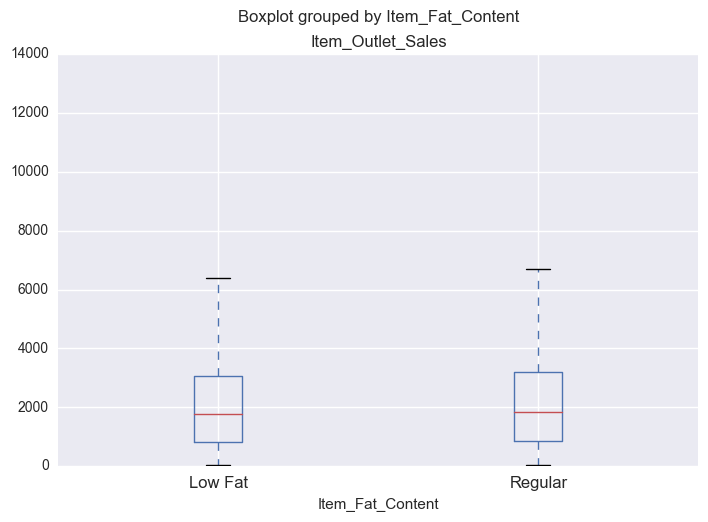

In [10]:
print("Count of each item fat content:")
print(sales['Item_Fat_Content'].value_counts())
print("")
print("Mean Item outlet sales:")
fatcontent_sales = sales[['Item_Fat_Content','Item_Outlet_Sales']].groupby('Item_Fat_Content').mean()
print(fatcontent_sales)
sales.boxplot(column='Item_Outlet_Sales',by='Item_Fat_Content')

In [11]:
'''
Null hypothesis: Means of both the items are same
Alternate      : Not same
'''

low_fat = sales[sales['Item_Fat_Content'] == 'Low Fat']
regular = sales[sales['Item_Fat_Content'] == 'Regular']

low_fat = low_fat[['Item_Outlet_Sales']]
regular = regular[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(low_fat,regular))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Item_Fat_Content, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 2.98666429]), pvalue=array([ 0.08398917]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower   upper   reject
------------------------------------------------
Low Fat Regular 66.8496  -8.9759 142.6752 False 
------------------------------------------------


In [12]:
# since p-value > 0.05, we cannot reject the null hypothesis and conclude that the mean difference between both the items are 
# indeed same.

#### Itemtype VS sales

Count of each item type:
Food              6125
Non-consumable    1599
Drinks             799
Name: Item_type_new, dtype: int64

Mean Item outlet sales:
                Item_Outlet_Sales
Item_type_new                    
Drinks                1997.333337
Food                  2215.354223
Non-consumable        2142.721364


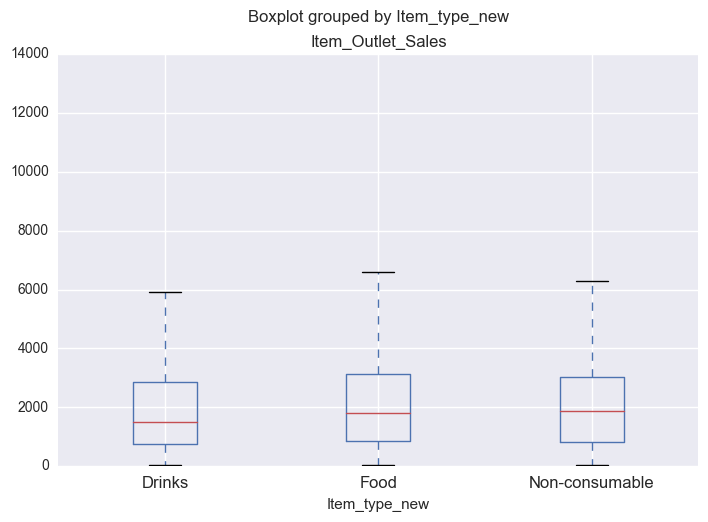

In [13]:
print("Count of each item type:")
print(sales['Item_type_new'].value_counts())
print("")
print("Mean Item outlet sales:")
itemtype_sales = sales[['Item_type_new','Item_Outlet_Sales']].groupby('Item_type_new').mean()
print(itemtype_sales)
sales.boxplot(column='Item_Outlet_Sales',by='Item_type_new')

In [14]:
'''
Null hypothesis: Means of all three items are same
Alternate      : Not same
'''

food = sales[sales['Item_type_new'] == 'Food']
drinks = sales[sales['Item_type_new'] == 'Drinks']
nc = sales[sales['Item_type_new'] == 'Non-consumable']

food = food[['Item_Outlet_Sales']]
drinks = drinks[['Item_Outlet_Sales']]
nc = nc[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(food,drinks, nc))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Item_type_new, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 6.27876568]), pvalue=array([ 0.00188441]))

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1     group2     meandiff   lower    upper   reject
--------------------------------------------------------
Drinks      Food      218.0209  67.6481  368.3937  True 
Drinks Non-consumable 145.388   -27.8105 318.5865 False 
 Food  Non-consumable -72.6329 -184.9022 39.6364  False 
--------------------------------------------------------


In [15]:
'''
overall p-value < 0.05, so we reject the null hypothesis and conclude that atleast 1 group's mean is different from the others.
Also, tukey test confirmed that only the mean difference between drinks and food is significantly different.

Now, the meandiff between [drinks & nc] and [food & nc] are 145 and 72 respectively. Since differnce between food and nc are 
much lower, so both these groups will be grouped together.
'''
#grouping food and NC together --- into "other"

sales = sales.replace({'Item_type_new' : { 'Food' : 'other', 'Non-consumable' : 'other'}})

In [16]:
drinks = sales[sales['Item_type_new'] == 'Drinks']
others = sales[sales['Item_type_new'] == 'other']

drinks = drinks[['Item_Outlet_Sales']]
others = others[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(others,drinks))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Item_type_new, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 10.25609369]), pvalue=array([ 0.00136735]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper   reject
----------------------------------------------
Drinks other  202.9846 78.7388 327.2305  True 
----------------------------------------------


In [17]:
# with p-value < 0.05, we have a significant difference between these 2 groups.

#### Outlet size

Count of each outlet size:
Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Mean Item outlet sales:
             Item_Outlet_Sales
Outlet_Size                   
High               2298.995256
Medium             2283.730470
Small              1912.149161


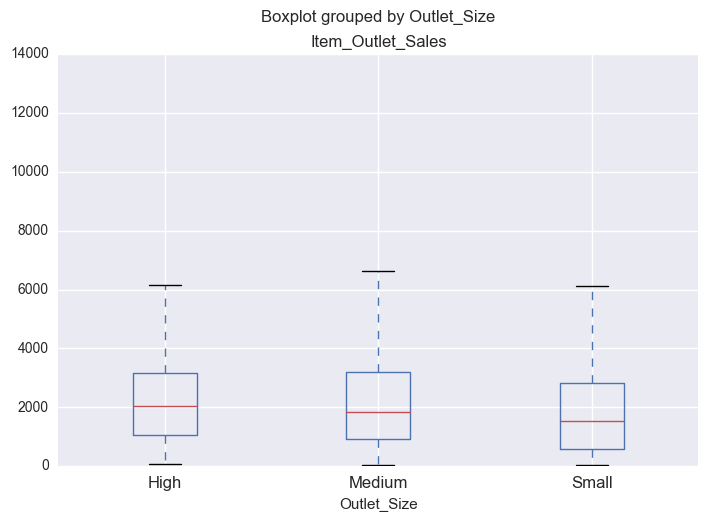

In [18]:
print("Count of each outlet size:")
print(sales['Outlet_Size'].value_counts())
print("")
print("Mean Item outlet sales:")
outletsize_sales = sales[['Outlet_Size','Item_Outlet_Sales']].groupby('Outlet_Size').mean()
print(outletsize_sales)
sales.boxplot(column='Item_Outlet_Sales',by='Outlet_Size')

In [19]:
'''
Null hypothesis: Means of all three items are same
Alternate      : Not same
'''

high = sales[sales['Outlet_Size'] == 'High']
med = sales[sales['Outlet_Size'] == 'Medium']
small = sales[sales['Outlet_Size'] == 'Small']

high = high[['Item_Outlet_Sales']]
med = med[['Item_Outlet_Sales']]
small = small[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(high,med, small))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Outlet_Size, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 41.68553755]), pvalue=array([  9.64280395e-19]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
 High  Medium  -15.2648 -156.8751  126.3455 False 
 High  Small  -386.8461 -540.6142  -233.078  True 
Medium Small  -371.5813 -469.9887 -273.1739  True 
--------------------------------------------------


In [20]:
'''
Although we have an overall significance with p-value < 0.05, from tukey test we got that only mean difference between [high & 
medium] is not significant. So, these groups will be grouped together.
'''

#grouping high and medium together --- into high

sales = sales.replace({'Outlet_Size' : { 'Medium' : 'High'}})

In [21]:
high = sales[sales['Outlet_Size'] == 'High']
small = sales[sales['Outlet_Size'] == 'Small']

high = high[['Item_Outlet_Sales']]
small = small[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(high, small))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Outlet_Size, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 83.31637997]), pvalue=array([  8.60134453e-20]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
 High  Small  -373.9003 -454.1975 -293.6031  True 
--------------------------------------------------


In [22]:
# with p-value < 0.05, we have a significant difference between these 2 groups.

#### Outlet_Location_Type vs sales

Count of each outlet location type:
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Mean Item outlet sales:
                      Item_Outlet_Sales
Outlet_Location_Type                   
Tier 1                      1876.909159
Tier 2                      2323.990559
Tier 3                      2279.627651


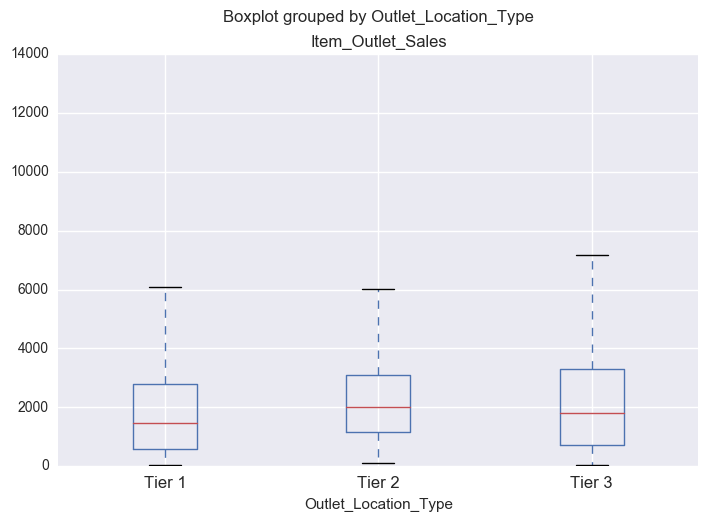

In [23]:
print("Count of each outlet location type:")
print(sales['Outlet_Location_Type'].value_counts())
print("")
print("Mean Item outlet sales:")
location_sales = sales[['Outlet_Location_Type','Item_Outlet_Sales']].groupby('Outlet_Location_Type').mean()
print(location_sales)
sales.boxplot(column='Item_Outlet_Sales',by='Outlet_Location_Type')

In [24]:
'''
Null hypothesis: Means of all three items are same
Alternate      : Not same
'''

tier1 = sales[sales['Outlet_Location_Type'] == 'Tier 1']
tier2 = sales[sales['Outlet_Location_Type'] == 'Tier 2']
tier3 = sales[sales['Outlet_Location_Type'] == 'Tier 3']

tier1 = tier1[['Item_Outlet_Sales']]
tier2 = tier2[['Item_Outlet_Sales']]
tier3 = tier3[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(tier1, tier2, tier3))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Outlet_Location_Type, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 53.94773987]), pvalue=array([  5.22281730e-24]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower    upper   reject
------------------------------------------------
Tier 1 Tier 2 447.0814  336.2033 557.9595  True 
Tier 1 Tier 3 402.7185  296.2441 509.1928  True 
Tier 2 Tier 3 -44.3629 -146.3104 57.5846  False 
------------------------------------------------


In [25]:
#again, grouping tier 2 and tier 3 together --- into tier 2

sales = sales.replace({'Outlet_Location_Type' : { 'Tier 3' : 'Tier 2'}})

tier1 = sales[sales['Outlet_Location_Type'] == 'Tier 1']
tier2 = sales[sales['Outlet_Location_Type'] == 'Tier 2']

tier1 = tier1[['Item_Outlet_Sales']]
tier2 = tier2[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(tier1, tier2))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Outlet_Location_Type, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 106.85446141]), pvalue=array([  6.72037460e-25]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
Tier 1 Tier 2 422.8572 342.6696 503.0447  True 
-----------------------------------------------


In [26]:
# with p-value < 0.05, we have a significant difference between these 2 groups.

#### Outlet_Type vs sales

Count of each outlet type:
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

Mean Item outlet sales:
                   Item_Outlet_Sales
Outlet_Type                         
Grocery Store             339.828500
Supermarket Type1        2316.181148
Supermarket Type2        1995.498739
Supermarket Type3        3694.038558


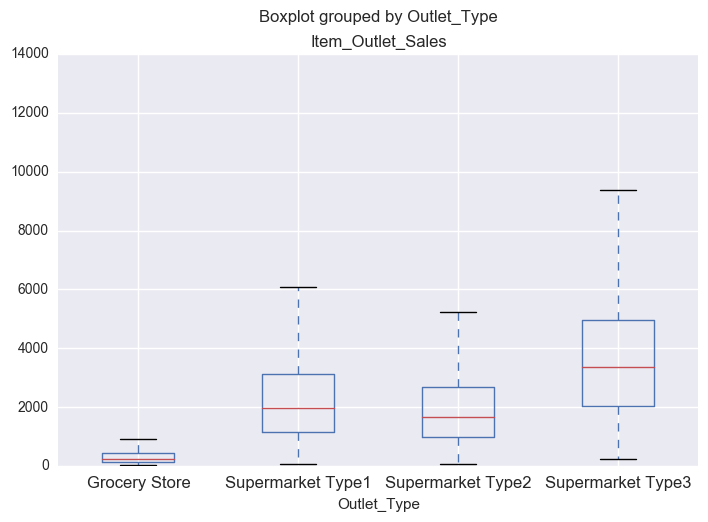

In [27]:
print("Count of each outlet type:")
print(sales['Outlet_Type'].value_counts())
print("")
print("Mean Item outlet sales:")
outlettype_sales = sales[['Outlet_Type','Item_Outlet_Sales']].groupby('Outlet_Type').mean()
print(outlettype_sales)
sales.boxplot(column='Item_Outlet_Sales',by='Outlet_Type')

In [28]:
'''
Null hypothesis: Means of all 4 items are same
Alternate      : Not same
'''

groc = sales[sales['Outlet_Type'] == 'Grocery Store']
type1 = sales[sales['Outlet_Type'] == 'Supermarket Type1']
type2 = sales[sales['Outlet_Type'] == 'Supermarket Type2']
type3 = sales[sales['Outlet_Type'] == 'Supermarket Type3']

groc = groc[['Item_Outlet_Sales']]
type1 = type1[['Item_Outlet_Sales']]
type2 = type2[['Item_Outlet_Sales']]
type3 = type3[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(groc, type1, type2, type3))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Outlet_Type, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 894.6500119]), pvalue=array([ 0.]))

           Multiple Comparison of Means - Tukey HSD,FWER=0.05           
      group1            group2       meandiff   lower     upper   reject
------------------------------------------------------------------------
  Grocery Store   Supermarket Type1 1976.3526 1849.3577 2103.3476  True 
  Grocery Store   Supermarket Type2 1655.6702 1484.5971 1826.7434  True 
  Grocery Store   Supermarket Type3 3354.2101 3183.4821  3524.938  True 
Supermarket Type1 Supermarket Type2 -320.6824 -456.2679 -185.0969  True 
Supermarket Type1 Supermarket Type3 1377.8574 1242.7077 1513.0071  True 
Supermarket Type2 Supermarket Type3 1698.5398 1521.3288 1875.7508  True 
------------------------------------------------------------------------


In [29]:
# all the groups are different from each other.

#### Item_Weight vs Item_Outlet_Sales

                   Item_Weight  Item_Outlet_Sales
Item_Weight           1.000000           0.012088
Item_Outlet_Sales     0.012088           1.000000


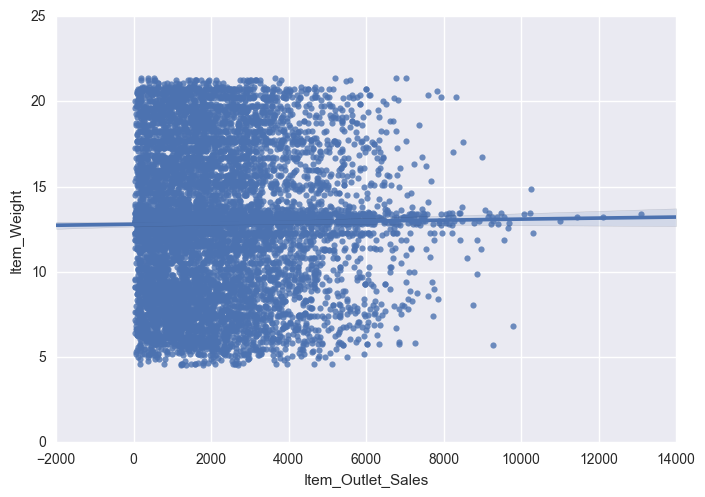

In [30]:
print(sales[['Item_Weight','Item_Outlet_Sales']].corr())
import seaborn as sns
sns.regplot(x="Item_Outlet_Sales", y="Item_Weight", data=sales)

In [31]:
sales.Item_Weight.describe()

count    8523.000000
mean       12.857890
std         4.232804
min         4.555000
25%         9.310000
50%        12.867061
75%        16.000000
max        21.350000
Name: Item_Weight, dtype: float64

In [32]:
'''
Since, the correlation between Item_Weight and the response variable is very less, merely 1.2%, this is not gonna help in our
prediction.
So,lets break this up into 3 groups: [0 - 25th percentile - 75th percentile - 100th perentile]
'''
sales['Item_Weight'] = pd.cut(sales['Item_Weight'], bins=[0,9,16,22], labels = ['low','med','high'])

low = sales[sales['Item_Weight'] == 'low']
med = sales[sales['Item_Weight'] == 'med']
high = sales[sales['Item_Weight'] == 'high']


low = low[['Item_Outlet_Sales']]
med = med[['Item_Outlet_Sales']]
high = high[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(low, med, high))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Item_Weight, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 9.489304]), pvalue=array([  7.64593917e-05]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower    upper   reject
------------------------------------------------
 high   low   -72.9083 -198.2902 52.4736  False 
 high   med   118.0813  12.6793  223.4834  True 
 low    med   190.9896  82.4292  299.5501  True 
------------------------------------------------


             Item_Outlet_Sales
Item_Weight                   
low                2063.364443
med                2254.354084
high               2136.272771


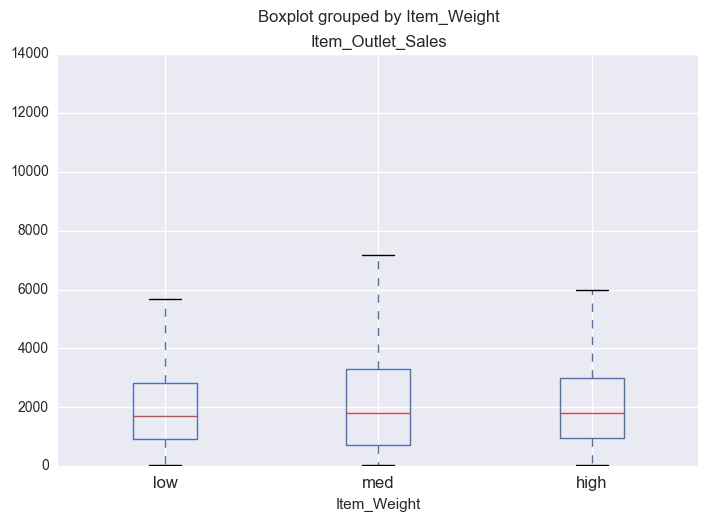

In [33]:
weight_sales = sales[['Item_Weight','Item_Outlet_Sales']].groupby('Item_Weight').mean()
print(weight_sales)
sales.boxplot(column='Item_Outlet_Sales',by='Item_Weight')

In [34]:
# grouping high and low together

sales["Item_Weight"]=sales["Item_Weight"].astype(object)
sales = sales.replace({'Item_Weight' : { 'low' : 'weights1','med':'weights2','high':'weights1'}})

In [35]:
wt1 = sales[sales['Item_Weight'] == 'weights1']
wt2 = sales[sales['Item_Weight'] == 'weights2']

wt1 = wt1[['Item_Outlet_Sales']]
wt2 = wt2[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(wt1, wt2))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Item_Weight, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 17.11889102]), pvalue=array([  3.54489646e-05]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
weights1 weights2 152.9684 80.4958 225.441  True 
-------------------------------------------------


In [36]:
# with p-value < 0.05, we have a significant difference between these 2 groups.

#### Item_Visibility vs sales

                   Item_Visibility  Item_Outlet_Sales
Item_Visibility           1.000000          -0.128625
Item_Outlet_Sales        -0.128625           1.000000


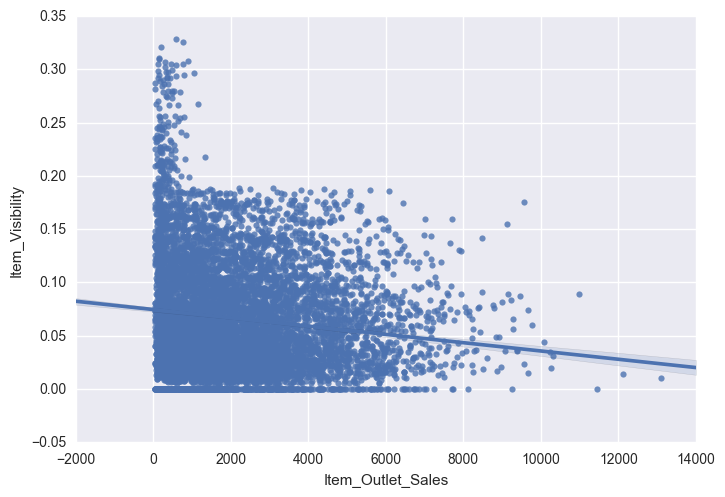

In [37]:
print(sales[['Item_Visibility','Item_Outlet_Sales']].corr())
import seaborn as sns
sns.regplot(x="Item_Outlet_Sales", y="Item_Visibility", data=sales)

In [38]:
sales['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

In [39]:
'''
Since, the correlation between Item_Visibility and the response variable is very less, just 12%, this is not gonna help in our
prediction.
So,lets break this up into 3 groups: [0 - 25th percentile - 75th percentile - 100th perentile]
'''

sales['Item_Visibility'] = pd.cut(sales['Item_Visibility'], bins = [-1,0.026, 0.094, 1], labels = ['low', 'med','high'])

low = sales[sales['Item_Visibility'] == 'low']
med = sales[sales['Item_Visibility'] == 'med']
high = sales[sales['Item_Visibility'] == 'high']


low = low[['Item_Outlet_Sales']]
med = med[['Item_Outlet_Sales']]
high = high[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(low, med, high))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Item_Visibility, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 50.83577395]), pvalue=array([  1.12978257e-22]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower    upper   reject
------------------------------------------------
 high   low   466.7087  343.3902 590.0273  True 
 high   med   400.9196  296.2636 505.5756  True 
 low    med   -65.7891 -173.0973  41.519  False 
------------------------------------------------


In [40]:
# grouping med and low together
sales["Item_Visibility"]=sales["Item_Visibility"].astype(object)
sales = sales.replace({'Item_Visibility' : { 'med':'low'}})

In [41]:
vis1 = sales[sales['Item_Visibility'] == 'low']
vis2 = sales[sales['Item_Visibility'] == 'high']

vis1 = vis1[['Item_Outlet_Sales']]
vis2 = vis2[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(vis1, vis2))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Item_Visibility, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 99.59370484]), pvalue=array([  2.51183136e-23]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
 high   low   421.6603 338.8362 504.4844  True 
-----------------------------------------------


#### Item_MRP vs sales

                   Item_MRP  Item_Outlet_Sales
Item_MRP           1.000000           0.567574
Item_Outlet_Sales  0.567574           1.000000


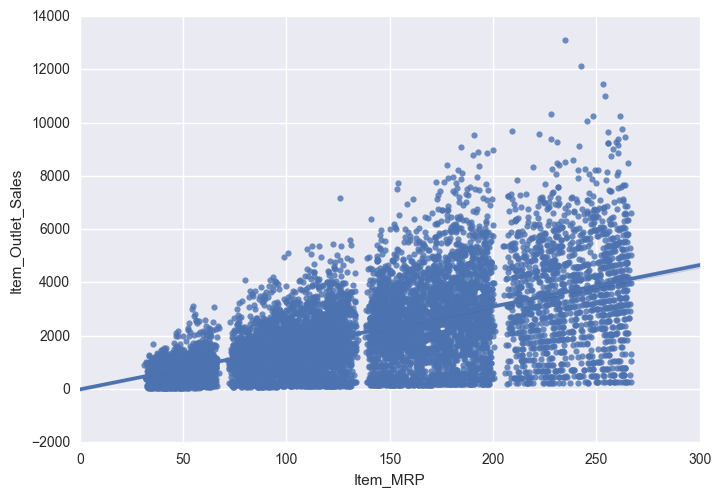

In [42]:
print(sales[['Item_MRP','Item_Outlet_Sales']].corr())
import seaborn as sns
sns.regplot(x="Item_MRP", y="Item_Outlet_Sales", data=sales)

In [43]:
# in this case, correlation between Itel_MRP and the response variable is good, with 56.7%
# i.e. with increase in $1 in item_mrp, outlet sales tend to increase by half of that amount.

#### Establishment year vs sales

                           Outlet_Establishment_Year  Item_Outlet_Sales
Outlet_Establishment_Year                   1.000000           0.049135
Item_Outlet_Sales                           0.049135           1.000000


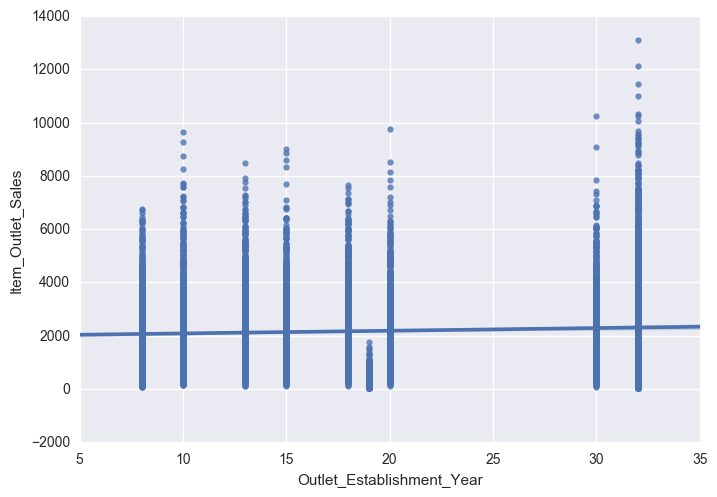

In [44]:
print(sales[['Outlet_Establishment_Year','Item_Outlet_Sales']].corr())
import seaborn as sns
sns.regplot(x="Outlet_Establishment_Year", y="Item_Outlet_Sales", data=sales)

In [45]:
sales['Outlet_Establishment_Year'].describe()

count    8523.000000
mean       19.168133
std         8.371760
min         8.000000
25%        13.000000
50%        18.000000
75%        30.000000
max        32.000000
Name: Outlet_Establishment_Year, dtype: float64

In [46]:
#very poor correlation, so divide it into groups.
sales['Outlet_Establishment_Year'] = pd.cut(sales['Outlet_Establishment_Year'], bins=[0,13,30,40], labels=['low','med','high'])

In [47]:
low = sales[sales['Outlet_Establishment_Year'] == 'low']
med = sales[sales['Outlet_Establishment_Year'] == 'med']
high = sales[sales['Outlet_Establishment_Year'] == 'high']


low = low[['Item_Outlet_Sales']]
med = med[['Item_Outlet_Sales']]
high = high[['Item_Outlet_Sales']]

from scipy import stats
print(stats.f_oneway(low, med, high))
print("")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(sales.Item_Outlet_Sales, sales.Outlet_Establishment_Year, alpha=0.05)
print(tukey.summary())

F_onewayResult(statistic=array([ 43.57980118]), pvalue=array([  1.47804104e-19]))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
 high   low   -225.2683 -353.8003  -96.7364  True 
 high   med   -456.0596 -576.6198 -335.4994  True 
 low    med   -230.7912 -327.7251 -133.8573  True 
--------------------------------------------------


                           Item_Outlet_Sales
Outlet_Establishment_Year                   
low                              2258.409145
med                              2027.617915
high                             2483.677474


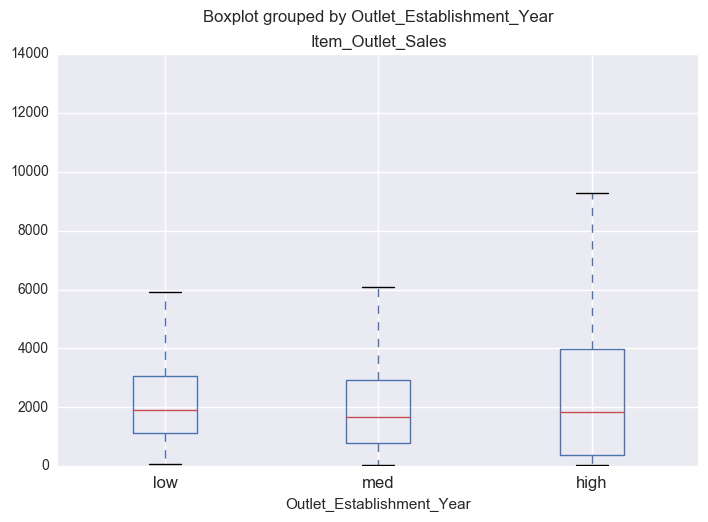

In [48]:
year_sales = sales[['Outlet_Establishment_Year','Item_Outlet_Sales']].groupby('Outlet_Establishment_Year').mean()
print(year_sales)
sales.boxplot(column='Item_Outlet_Sales',by='Outlet_Establishment_Year')

In [49]:
# with p-value < 0.05, we have a significant difference between these groups.

In [50]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_type_new
0,FDA15,weights2,Low Fat,low,Dairy,249.8092,OUT049,med,High,Tier 1,Supermarket Type1,3735.1380,other
1,DRC01,weights1,Regular,low,Soft Drinks,48.2692,OUT018,low,High,Tier 2,Supermarket Type2,443.4228,Drinks
2,FDN15,weights1,Low Fat,low,Meat,141.6180,OUT049,med,High,Tier 1,Supermarket Type1,2097.2700,other
3,FDX07,weights1,Regular,low,Fruits and Vegetables,182.0950,OUT010,med,High,Tier 2,Grocery Store,732.3800,other
4,NCD19,weights1,Low Fat,low,Household,53.8614,OUT013,med,High,Tier 2,Supermarket Type1,994.7052,other


In [51]:
sales.to_csv("new_sales_csv.csv", index = False)